## UMAP MNMG Visualization

In [1]:
from cuml.dask.manifold import UMAP as UMAP_MNMG
from cuml.manifold import UMAP

from dask_cuda import LocalCUDACluster
from dask.distributed import Client
import dask.array as da

import pickle
import matplotlib.pyplot as plt
import numpy as np

### Preprocess tasic2018 dataset
Generate the preprocessed dataset with the tasic2018_dataset_preprocessing.ipynb notebook in the tasic2018 directory

In [2]:
X = pickle.load(open("tasic2018/tasic2018_X.p", "rb"))
colors = pickle.load(open("tasic2018/tasic2018_y.p", "rb"))
n_samples = X.shape[0]

In [3]:
def plot_umap_mnmg(args):
    fig, ax = plt.subplots(len(args['sampling_ratio']), len(args['n_parts']),
                           sharex='col', sharey='row', figsize=(20,15))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    
    for a, n_parts in zip(ax[0], args['n_parts']):
        a.set_title("n_parts:{}".format(n_parts))

    for a, sampling_ratio in zip(ax[:,0], args['sampling_ratio']):
        a.set_ylabel("sampling_ratio:{}".format(sampling_ratio), rotation=0, size='large', labelpad=45)
    
    if n_parts > 1:
        cluster = LocalCUDACluster(n_workers=8, threads_per_worker=1)
        client = Client(cluster)
    
    for i, n_parts in enumerate(args['n_parts']):
        for j, sampling_ratio in enumerate(args['sampling_ratio']):        
            if n_parts == 1: # Local transformation
                local_model = UMAP(n_components=2, n_neighbors=args['n_neighbors'],
                                   n_epochs=args['n_epochs'], random_state=args['random_state'])
                local_model.fit(X)
                transformed = local_model.transform(X)
            else: # Distributed transformation
                
                # Number of samples for local train
                n_sampling = int(n_samples * sampling_ratio)
                
                # Generate local train data
                selection = np.random.choice(n_samples, n_sampling)
                lX = X[selection]
                
                # Number of samples per partition
                n_samples_per_part = int(n_samples / n_parts)
                
                # Generate partitioning of distributed data for inference
                chunks = [n_samples_per_part] * n_parts
                chunks[-1] += n_samples % n_samples_per_part
                chunks = tuple(chunks)
                dX = da.from_array(X, chunks=(chunks, -1))

                # Train local model
                local_model = UMAP(n_components=2, n_neighbors=args['n_neighbors'],
                                   n_epochs=args['n_epochs'], random_state=args['random_state'])
                local_model.fit(lX)
                
                # Pass trained model and perform distributed inference
                model = UMAP_MNMG(local_model)
                transformed = model.transform(dX).compute()
            
            # Plot transformed data
            ax[j, i].scatter(transformed[:,0], transformed[:,1], c=colors,
                             s=0.2, alpha=0.3, edgecolors='none')
            
    if n_parts > 1:
        client.close()

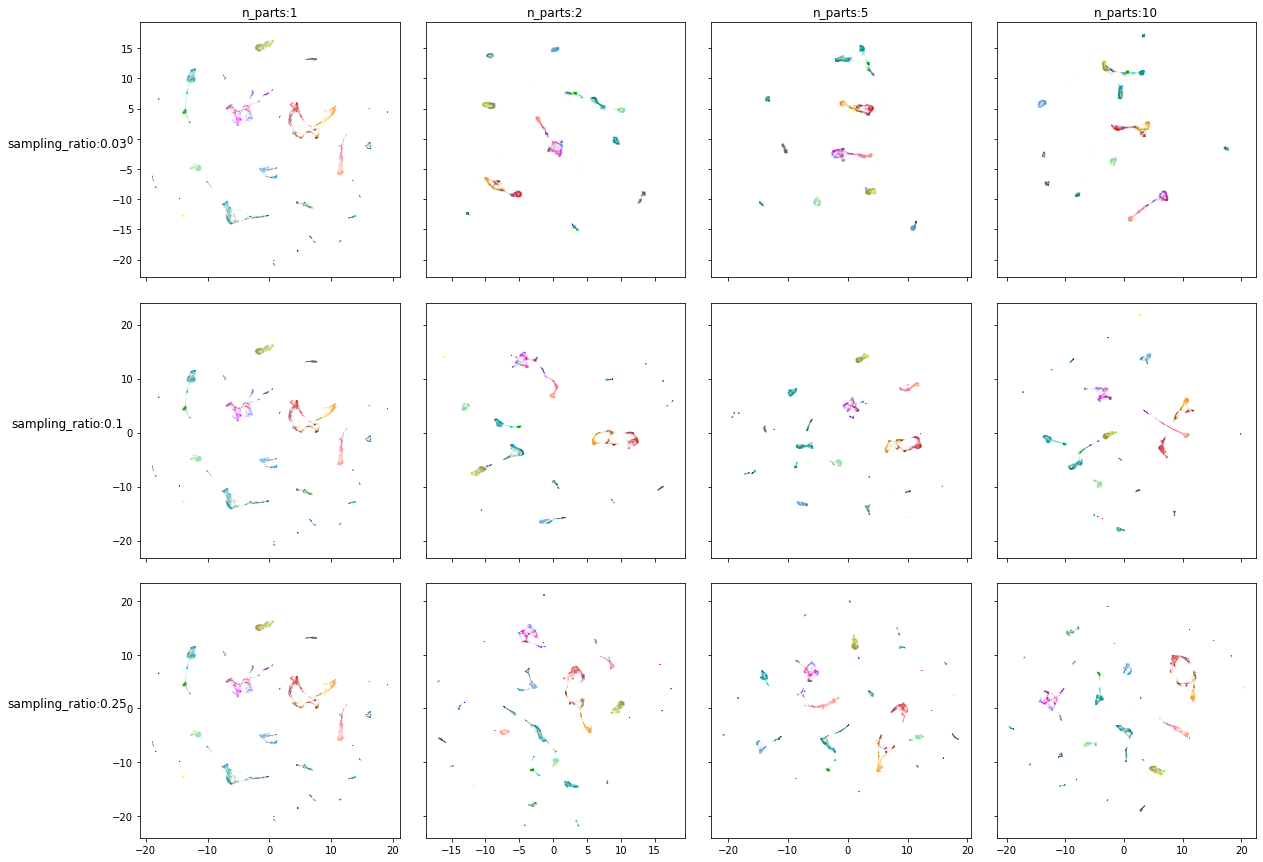

In [4]:
import warnings
warnings.filterwarnings('ignore')

args = {'n_neighbors':15, 'n_epochs':500, 'random_state': 42,
        'n_parts':[1,2,5,10], 'sampling_ratio':[0.03,0.1,0.25]}

plot_umap_mnmg(args)